# Proximal Policy Optimization using opimization of hyperparameters

**Author:** [Ali BaniAsad](https://github.com/alibaniasad1999)<br>
**Date created:** 2024/05/24<br>
**Last modified:** 2024/05/25<br>
**Description:** Implementation of a Proximal Policy Optimization agent for the CartPole-v1 environment.

In [111]:
# !pip install gymnasium
# !pip install --upgrade tensorflow
# !pip install --upgrade tf-keras
# !pip install --upgrade keras

In [112]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
# from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import lfilter

In [113]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [114]:
class MassSpringDamperEnv(gym.Env):

    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.step_num = None
        self.last_u = None
        self.state = None
        self.done = None
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # Integrator
        self.integral_error = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-20.0, high=20.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-100, high=100, shape=(3,))

    def step(self, action):
        # Apply control action and simulate one time step using Euler integration
        force = action[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.integral_error += position * self.dt


        costs = position ** 2 + 0.1 * velocity**2 \
        + 0.01 * self.integral_error**2 + 0.001 * (force**2)

        self.step_num += 1
        if self.step_num > 1000:
            self.done = True


        return self._get_obs(), -costs, self.done, False, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.state = np.random.uniform(low=-10, high=10, size=(2,))
        self.current_step = 0
        self.last_u = None
        self.done = False
        self.step_num = 0
        self.integral_error = 0


        return self._get_obs(), {}

    def _get_obs(self):
        position, velocity = self.state
        return np.array([position, velocity, self.integral_error], dtype=np.float32)

In [115]:
# Specify the `render_mode` parameter to show the attempts of the agent in a pop-up window.
env = MassSpringDamperEnv()

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  20.0
Min Value of Action ->  -20.0


# Proximal Policy Optimization Class

In [116]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

# Define the log-probabilities function for continuous actions
def logprobabilities(mean, log_std, actions):
    std = tf.exp(log_std)
    var = std ** 2
    # print(actions.dtype)
    # print(mean.dtype)
    # print(var.dtype)

    logp = -0.5 * (((actions - mean) ** 2) / var + 2 * log_std + tf.math.log(2 * np.pi))
    return tf.reduce_sum(logp, axis=-1)


class PPO:
    def __init__(self, env, size, gamma, lam, policy_learning_rate, value_function_learning_rate, epochs, clip_ratio,
                 steps_per_epoch, train_policy_iterations, target_kl, train_value_iterations,
                 actor_hidden_size, critic_hidden_size):
        self.train_value_iterations = train_value_iterations
        self.target_kl = target_kl
        self.train_policy_iterations = train_policy_iterations
        self.epochs = epochs
        self.clip_ratio = clip_ratio
        self.steps_per_epoch = steps_per_epoch
        # observation space and the number of possible actions
        observation_dimensions = env.observation_space.shape[0]
        num_actions = env.action_space.shape[0]
        # buffer init
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.float32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0
        # end buffer init

        # Define the observation input
        observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")
        
        # Define the actor model
        dense1_actor = keras.layers.Dense(actor_hidden_size[0], activation='relu')(observation_input)
        dense2_actor = keras.layers.Dense(actor_hidden_size[1], activation='relu')(dense1_actor)
        # add mean out put with tanh and upper and lower limit # Output mean of the Gaussian distribution
        mean_output = keras.layers.Dense(num_actions, activation='tanh')(dense2_actor) * env.action_space.high[0]
        log_std_output = keras.layers.Dense(num_actions, activation='tanh')(dense2_actor) # Output log standard deviation of the Gaussian distribution
        self.actor = keras.Model(inputs=observation_input, outputs=[mean_output, log_std_output])
        
        # Define the critic model
        dense1_critic = keras.layers.Dense(critic_hidden_size[0], activation='relu')(observation_input)
        dense2_critic = keras.layers.Dense(critic_hidden_size[1], activation='relu')(dense1_critic)
        value = keras.layers.Dense(1)(dense2_critic)  # Output single value for the critic
        self.critic = keras.Model(inputs=observation_input, outputs=value)
        
        # Initialize the policy and the value function optimizers
        self.policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
        self.value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

        self.episode_return, self.episode_length = 0, 0
        
    
    # buffer functions
    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )
    # end buffer functions

    # Sample action from an actor
    @tf.function
    def sample_action(self, observation, stochastic=True):
        # Get the mean and log standard deviation from the actor network
        mean, log_std = self.actor(observation)
    
        # Convert log standard deviation to standard deviation
        if stochastic:
            std = tf.exp(log_std)
        else:
            std = 0
    
        # Sample a continuous action from the Gaussian distribution
        action = mean + std * tf.random.normal(shape=mean.shape)
    
        return mean, log_std, action


    # Train the policy by maximizing the PPO-Clip objective
    @tf.function
    def train_policy(self,
        observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
    ):
        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            mean, log_std = self.actor(observation_buffer)
            ratio = tf.exp(
                logprobabilities(mean, log_std, action_buffer)
                - logprobability_buffer
            )
            min_advantage = tf.where(
                advantage_buffer > 0,
                (1 + self.clip_ratio) * advantage_buffer,
                (1 - self.clip_ratio) * advantage_buffer,
            )
    
            policy_loss = -tf.reduce_mean(
                tf.minimum(ratio * advantage_buffer, min_advantage)
            )
        policy_grads = tape.gradient(policy_loss, self.actor.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.actor.trainable_variables))
    
        mean, log_std = self.actor(observation_buffer)
        kl = logprobability_buffer - logprobabilities(mean, log_std, action_buffer)
        kl = tf.reduce_sum(kl)
        return kl
    
    
    # Train the value function by regression on mean-squared error
    @tf.function
    def train_value_function(self, observation_buffer, return_buffer):
        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            value_loss = keras.ops.mean((return_buffer - self.critic(observation_buffer)) ** 2)
        value_grads = tape.gradient(value_loss, self.critic.trainable_variables)
        self.value_optimizer.apply_gradients(zip(value_grads, self.critic.trainable_variables))
        
    # train function
    def train(self):
        # Initialize the observation, episode return and episode length
        observation, _ = env.reset()
        # reward list
        rewards = []
        # Iterate over the number of epochs
        for epoch in range(self.epochs):
            # Initialize the sum of the returns, lengths and number of episodes for each epoch
            sum_return = 0
            sum_length = 0
            num_episodes = 0
        
            # Iterate over the steps of each epoch
            for t in range(self.steps_per_epoch):
        
                # Get the logits, action, and take one step in the environment
                observation = observation.reshape(1, -1)
                mean, log_std, action = self.sample_action(observation)
                observation_new, reward, done, _, _ = env.step(action[0].numpy())
                self.episode_return += reward
                self.episode_length += 1
        
                # Get the value and log-probability of the action
                value_t = self.critic(observation)
                logprobability_t = logprobabilities(mean, log_std, action)
        
                # Store obs, act, rew, v_t, logp_pi_t
                self.store(observation, action, reward, value_t, logprobability_t)
        
                # Update the observation
                observation = observation_new
        
                # Finish trajectory if reached to a terminal state
                terminal = done
                if terminal or (t ==  self.steps_per_epoch - 1):
                    last_value = 0 if done else self.critic(observation.reshape(1, -1))
                    self.finish_trajectory(last_value)
                    sum_return += self.episode_return
                    sum_length += self.episode_length
                    num_episodes += 1
                    observation, _ = env.reset()
                    self.episode_return, self.episode_length = 0, 0
        
            # Get values from the buffer
            (
                observation_buffer,
                action_buffer,
                advantage_buffer,
                return_buffer,
                logprobability_buffer,
            ) = self.get()
        
            # Update the policy and implement early stopping using KL divergence
            for _ in range(self.train_policy_iterations):
                kl = self.train_policy(
                    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
                )
                if kl > 1.5 * self.target_kl:
                    # Early Stopping
                    break
        
            # Update the value function
            for _ in range(self.train_value_iterations):
                self.train_value_function(observation_buffer, return_buffer)
        
            # Print mean return and length for each epoch
            print(
                f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
            )
            rewards.append(sum_return / num_episodes)
        
        # Close the environment
        env.close()
        
        # plot rewards
        ax = plt.figure().gca()
        plt.plot(np.linspace(1, self.epochs, self.epochs), rewards)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # return mean reward
        return np.mean(rewards) 
        
    def test(self):
        # test the agent
        observation, _ = env.reset()
        done = False
        total_reward = 0
        states = []
        actions = []
        while not done:
            mean, log_std, action = self.sample_action(observation.reshape(1, -1), stochastic=False)
            observation, reward, done, _, _ = env.step(action[0].numpy())
            total_reward += reward
            states.append(observation)
            actions.append(action)
        print("Total Reward: ", total_reward)
        
        # Use XKCD style for hand-drawn look
        dt = env.dt
        time = np.arange(0, len(states)*dt, dt)
        with plt.xkcd():
            plt.plot(time, np.array(states))
            plt.xlabel("Time (sec)")
            plt.ylabel("State")
            plt.legend(["position", "velocity", "integral error"])
            plt.show()
        
        # Use XKCD style for hand-drawn look
        with plt.xkcd():
            plt.plot(time, np.array(actions).reshape(-1, 1))
            plt.xlabel("Time (sec)")
            plt.ylabel("action (N)")
            plt.show()



In [117]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 4000
buffer_size = steps_per_epoch
epochs = 10
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
actor_hidden_size = (64, 64) 
critic_hidden_size = (64, 64) 

In [118]:
ppo = PPO(env, buffer_size, gamma, lam, policy_learning_rate, value_function_learning_rate, epochs, clip_ratio,
          steps_per_epoch, train_policy_iterations, target_kl, train_value_iterations,
          actor_hidden_size, critic_hidden_size)  

 Epoch: 1. Mean Return: -661713.7944184789. Mean Length: 1000.0
 Epoch: 2. Mean Return: -555891.0170689325. Mean Length: 1000.0
 Epoch: 3. Mean Return: -428521.73495242407. Mean Length: 1000.0
 Epoch: 4. Mean Return: -711365.6041900725. Mean Length: 1000.0
 Epoch: 5. Mean Return: -538429.7520789271. Mean Length: 1000.0
 Epoch: 6. Mean Return: -544758.5856279427. Mean Length: 1000.0
 Epoch: 7. Mean Return: -933044.4618418362. Mean Length: 1000.0
 Epoch: 8. Mean Return: -560255.1642133783. Mean Length: 1000.0
 Epoch: 9. Mean Return: -459989.4353618309. Mean Length: 1000.0
 Epoch: 10. Mean Return: -972712.4253414162. Mean Length: 1000.0
-636668.1975095238


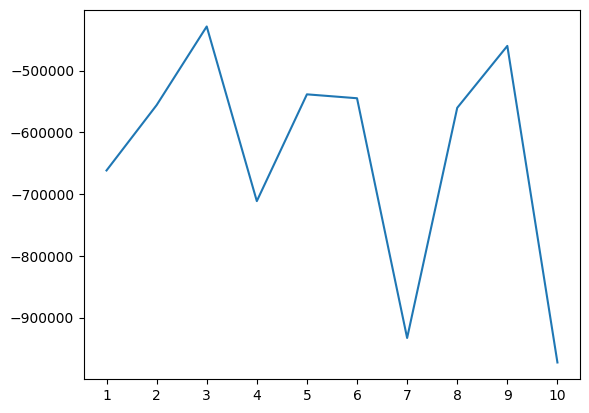

In [119]:
print(ppo.train())

Total Reward:  -740154.0892819384


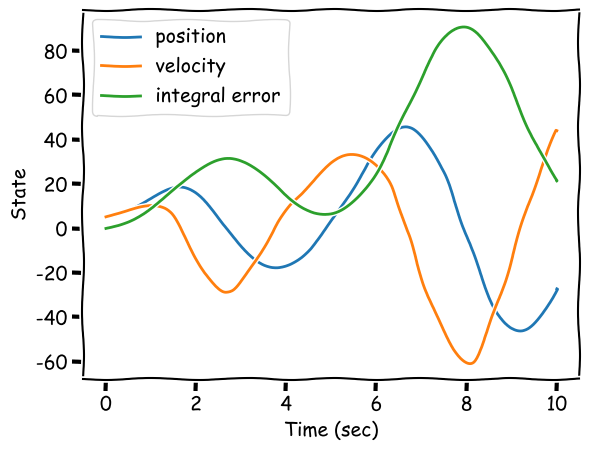

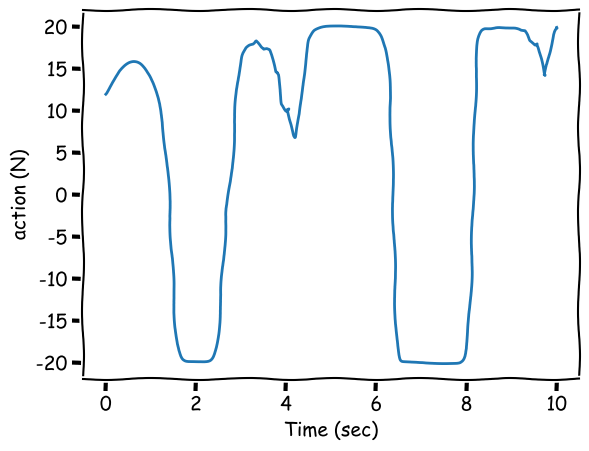

In [120]:
ppo.test()

In [121]:
import optuna
def objective(trial):
    # Suggest hyperparameters
    steps_per_epoch = trial.suggest_int("steps_per_epoch", 1000, 5000)
    buffer_size = steps_per_epoch
    epochs = trial.suggest_int("epochs", 1, 10)
    gamma = trial.suggest_float("gamma", 0.9, 0.999, step=0.001)
    clip_ratio = trial.suggest_float("clip_ratio", 0.1, 0.3, step=0.05)
    policy_learning_rate = trial.suggest_float("policy_learning_rate", 1e-5, 1e-3, log=True)
    value_function_learning_rate = trial.suggest_float("value_function_learning_rate", 1e-5, 1e-3, log=True)
    train_policy_iterations = trial.suggest_int("train_policy_iterations", 10, 100)
    train_value_iterations = trial.suggest_int("train_value_iterations", 10, 100)
    lam = trial.suggest_float("lam", 0.9, 0.99, step=0.01)
    target_kl = trial.suggest_float("target_kl", 0.001, 0.05, step=0.001)
    actor_hidden_size1 = trial.suggest_int("hidden_size1", 5, 10,  log=True)
    actor_hidden_size2 = trial.suggest_int("hidden_size2", 5, 10,  log=True)
    critic_hidden_size1 = trial.suggest_int("hidden_size3", 5, 10, log=True)
    critic_hidden_size2 = trial.suggest_int("hidden_size4", 5, 10, log=True)

    actor_hidden_sizes = (actor_hidden_size1 ** 2, actor_hidden_size2 ** 2)
    critic_hidden_sizes = (critic_hidden_size1 ** 2, critic_hidden_size2 ** 2)
    
    
    
    
    ppo = PPO(env, buffer_size, gamma, lam, policy_learning_rate, value_function_learning_rate, epochs, clip_ratio,
          steps_per_epoch, train_policy_iterations, target_kl, train_value_iterations,
          actor_hidden_sizes, critic_hidden_sizes) 
    
    return ppo.train()

In [ ]:
# time to learn
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Best trial:")
trial = study.best_trial
print(trial.values)
print(trial.params)